In [1]:
##############################################################################
#                      Importa as bibliotecas                                #
##############################################################################
import os
import pandas as pd
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import sklearn.metrics as metrics
import numpy as np

import json

import time

import argparse
from sklearn.utils import class_weight

from sklearn import tree
np.random.seed(5)

In [2]:
##############################################################################
#                            Declara as funções                              #
##############################################################################
def GetFileClass(x):
    # Retorna se o caminho da imagem é da classe positive ou negative
    # Parameters:
    #    x(str): String com o caminho da imagem.
    # Returns:
    #    (str): String com a classe correta do caminho.   
    if 'Positive' in x:
        return 1
    else:
        return 0
    
    
def GetMetrics(y_pred, y_test):
    tn, fp, fn, tp = metrics.confusion_matrix(list(y_test), list(y_pred)).ravel()
    acc = ((tp + tn)/(tn + fp + fn + tp))
    pr = tp/(tp + fp)
    re = tp/(tp + fn)
    f1 = 2*((pr*re)/(pr+re))
    return {'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp, 'ACC': acc, 'PR': pr, 'RE': re, 'F1': f1, 'Erro': 1 - acc}

100%|████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:03<00:00, 1050.50it/s]


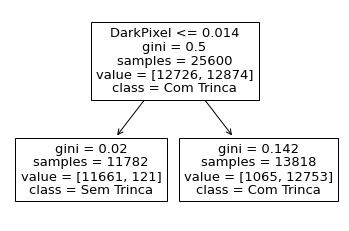

,TN,FP,FN,TP,ACC,PR,RE,F1,Erro
Mode,,,,,,,,,
Validação,3023,251,21,3105,0.95750,0.925209,0.993282,0.958038,0.04250
Teste,3692,308,38,3962,0.95675,0.927869,0.990500,0.958162,0.04325


In [3]:
##############################################################################
#              Declaração dos parâmetros globais do código                   #
##############################################################################       
# Caminhos para as bases de teste e treino
PathTrainData = os.path.join('Dataset', 'METU', 'training_set')

# Caminhos para as bases de teste e treino
PathTestData = os.path.join('Dataset', 'METU', 'test_set')

# Tamanho da imagem para o modelo
InputSize = (96, 96, 3)
ModelImgSize = (96, 96)

##############################################################################
#      Faz a leitura dos caminhos das imagens e transforma em DataFrame      #
##############################################################################  
TrainFiles = []
for path, subdirs, files in os.walk(PathTrainData):
    for name in files:
        TrainFiles.append(os.path.join(path, name))

df_train = pd.DataFrame(TrainFiles, columns = ['FilePath'])
   
##############################################################################
#      Faz a leitura dos caminhos das imagens e transforma em DataFrame      #
##############################################################################  
TestFiles = []
for path, subdirs, files in os.walk(PathTestData):
    for name in files:
        TestFiles.append(os.path.join(path, name))

df_test = pd.DataFrame(TestFiles, columns = ['FilePath'])

##############################################################################
#                Obtem qual é a classe que o caminho pertence                #
##############################################################################  
df_train['Class'] = df_train['FilePath'].apply(GetFileClass)
df_test['Class'] = df_test['FilePath'].apply(GetFileClass)

##############################################################################
#          Cria um subset de validação apartir da base de treinamento        #
##############################################################################
df_train, df_val = train_test_split(df_train, test_size = 0.2, random_state = 42)

##############################################################################
#              Split dataset into positive and negative class                #
##############################################################################
df_train_positive = df_train[df_train['Class'] == 1].reset_index(drop = True)
df_train_negative = df_train[df_train['Class'] == 0].reset_index(drop = True)

df_val_positive = df_val[df_val['Class'] == 1].reset_index(drop = True)
df_val_negative = df_val[df_val['Class'] == 0].reset_index(drop = True)

df_test_positive = df_test[df_test['Class'] == 1].reset_index(drop = True)
df_test_negative = df_test[df_test['Class'] == 0].reset_index(drop = True)

##############################################################################
#                          Load training images                              #
##############################################################################
positive_train_df = []
for i in tqdm(range(len(df_train_positive))):
    ret2, th2 = cv2.threshold(cv2.resize(cv2.imread(df_train_positive.loc[i, 'FilePath'], 0), ModelImgSize, interpolation = cv2.INTER_AREA), 127, 255, cv2.THRESH_BINARY)
    histogram, bin_edges = np.histogram(th2, bins = 255)
    positive_train_df.append([histogram[0], histogram[-1], 1])
positive_train_df = pd.DataFrame(positive_train_df, columns = ['DarkPixel', 'LightPixel', 'Class'])
    
negative_train_df = []
for i in tqdm(range(len(df_train_negative))):
    ret2, th2 = cv2.threshold(cv2.resize(cv2.imread(df_train_negative.loc[i, 'FilePath'], 0), ModelImgSize, interpolation = cv2.INTER_AREA), 127, 255, cv2.THRESH_BINARY)
    histogram, bin_edges = np.histogram(th2, bins = 255)
    negative_train_df.append([histogram[0], histogram[-1], 0])
    
negative_train_df = pd.DataFrame(negative_train_df, columns = ['DarkPixel', 'LightPixel', 'Class'])

df_train_otsu = pd.concat([positive_train_df, negative_train_df], axis = 0).reset_index(drop = True)
df_train_otsu = df_train_otsu.sample(frac = 1).reset_index(drop = True)

##############################################################################
#                          Load validation images                            #
##############################################################################
positive_val_df = []
for i in tqdm(range(len(df_val_positive))):
    ret2, th2 = cv2.threshold(cv2.resize(cv2.imread(df_val_positive.loc[i, 'FilePath'], 0), ModelImgSize, interpolation = cv2.INTER_AREA), 127, 255, cv2.THRESH_BINARY)
    histogram, bin_edges = np.histogram(th2, bins = 255)
    positive_val_df.append([histogram[0], histogram[-1], 1])
positive_val_df = pd.DataFrame(positive_val_df, columns = ['DarkPixel', 'LightPixel', 'Class'])
    
negative_val_df = []
for i in tqdm(range(len(df_val_negative))):
    ret2, th2 = cv2.threshold(cv2.resize(cv2.imread(df_val_negative.loc[i, 'FilePath'], 0), ModelImgSize, interpolation = cv2.INTER_AREA), 127, 255, cv2.THRESH_BINARY)
    histogram, bin_edges = np.histogram(th2, bins = 255)
    negative_val_df.append([histogram[0], histogram[-1], 0])
negative_val_df = pd.DataFrame(negative_val_df, columns = ['DarkPixel', 'LightPixel', 'Class'])

df_val_otsu = pd.concat([positive_val_df, negative_val_df], axis = 0).reset_index(drop = True)
df_val_otsu = df_val_otsu.sample(frac = 1).reset_index(drop = True)


##############################################################################
#                          Load test images                                  #
##############################################################################
positive_test_df = []
for i in tqdm(range(len(df_test_positive))):
    ret2, th2 = cv2.threshold(cv2.resize(cv2.imread(df_test_positive.loc[i, 'FilePath'], 0), ModelImgSize, interpolation = cv2.INTER_AREA), 127, 255, cv2.THRESH_BINARY)
    histogram, bin_edges = np.histogram(th2, bins = 255)
    positive_test_df.append([histogram[0], histogram[-1], 1])
positive_test_df = pd.DataFrame(positive_test_df, columns = ['DarkPixel', 'LightPixel', 'Class'])
    
negative_test_df = []
for i in tqdm(range(len(df_test_negative))):
    ret2, th2 = cv2.threshold(cv2.resize(cv2.imread(df_test_negative.loc[i, 'FilePath'], 0), ModelImgSize, interpolation = cv2.INTER_AREA), 127, 255, cv2.THRESH_BINARY)
    histogram, bin_edges = np.histogram(th2, bins = 255)
    negative_test_df.append([histogram[0], histogram[-1], 0])
negative_test_df = pd.DataFrame(negative_test_df, columns = ['DarkPixel', 'LightPixel', 'Class'])

df_test_otsu = pd.concat([positive_test_df, negative_test_df], axis = 0).reset_index(drop = True)
df_test_otsu = df_test_otsu.sample(frac = 1).reset_index(drop = True)


##############################################################################
#                        Normaliza as bases de dados                         #
##############################################################################
df_train_otsu['DarkPixel'] = df_train_otsu['DarkPixel']/(96*96)
df_train_otsu['LightPixel'] = df_train_otsu['LightPixel']/(96*96)

df_val_otsu['DarkPixel'] = df_val_otsu['DarkPixel']/(96*96)
df_val_otsu['LightPixel'] = df_val_otsu['LightPixel']/(96*96)

df_test_otsu['DarkPixel'] = df_test_otsu['DarkPixel']/(96*96)
df_test_otsu['LightPixel'] = df_test_otsu['LightPixel']/(96*96)

##############################################################################
#                          Treina o classificador                            #
##############################################################################
clf = tree.DecisionTreeClassifier(max_leaf_nodes = 2)

clf.fit(df_train_otsu.drop(columns = 'Class'), df_train_otsu['Class'])

##############################################################################
#                          Plota a arvore de decisão                         #
##############################################################################
tree.plot_tree(clf, feature_names = ['DarkPixel', 'LightPixel'], class_names = ['Sem Trinca', 'Com Trinca'])
plt.show()

##############################################################################
#                          Valida o classificador                            #
##############################################################################
full_data = []
y_pred = clf.predict(df_val_otsu.drop(columns = 'Class'))
aux_dict = GetMetrics(y_pred, df_val_otsu['Class'])
aux_dict['Mode'] = 'Validação'
full_data.append(aux_dict)

##############################################################################
#                          Testa o classificador                             #
##############################################################################
aux_dict = GetMetrics(clf.predict(df_test_otsu.drop(columns = 'Class')), df_test_otsu['Class'])
aux_dict['Mode'] = 'Teste'
full_data.append(aux_dict)

##############################################################################
#                             Display dos dados                              #
##############################################################################
full_data = pd.DataFrame.from_dict(full_data).set_index('Mode')
display(full_data)

In [4]:
print(full_data.to_markdown())

| Mode      |   TN |   FP |   FN |   TP |     ACC |       PR |       RE |       F1 |    Erro |
|:----------|-----:|-----:|-----:|-----:|--------:|---------:|---------:|---------:|--------:|
| Validação | 3023 |  251 |   21 | 3105 | 0.9575  | 0.925209 | 0.993282 | 0.958038 | 0.0425  |
| Teste     | 3692 |  308 |   38 | 3962 | 0.95675 | 0.927869 | 0.9905   | 0.958162 | 0.04325 |


100%|█████████████████████████████████████████████████████████████████████████████| 9522/9522 [00:11<00:00, 841.99it/s]


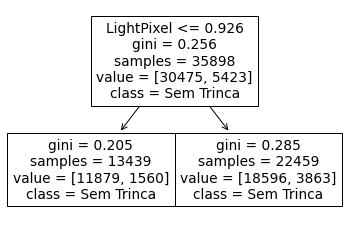

<ipython-input-2-be15393e2741>:19: RuntimeWarning: invalid value encountered in longlong_scalars
  pr = tp/(tp + fp)
<ipython-input-2-be15393e2741>:19: RuntimeWarning: invalid value encountered in longlong_scalars
  pr = tp/(tp + fp)


,TN,FP,FN,TP,ACC,PR,RE,F1,Erro
Mode,,,,,,,,,
Validação,7611,0,1364,0,0.848022,0.0,0.0,0.0,0.151978
Teste,9522,0,1697,0,0.848739,0.0,0.0,0.0,0.151261


In [5]:
##############################################################################
#              Declaração dos parâmetros globais do código                   #
##############################################################################       
# Caminhos para as bases de teste e treino
PathTrainData = os.path.join('Dataset', 'SDNET_2018', 'training_set')

# Caminhos para as bases de teste e treino
PathTestData = os.path.join('Dataset', 'SDNET_2018', 'test_set')

# Tamanho da imagem para o modelo
InputSize = (96, 96, 3)
ModelImgSize = (96, 96)

##############################################################################
#      Faz a leitura dos caminhos das imagens e transforma em DataFrame      #
##############################################################################  
TrainFiles = []
for path, subdirs, files in os.walk(PathTrainData):
    for name in files:
        TrainFiles.append(os.path.join(path, name))

df_train = pd.DataFrame(TrainFiles, columns = ['FilePath'])
   
##############################################################################
#      Faz a leitura dos caminhos das imagens e transforma em DataFrame      #
##############################################################################  
TestFiles = []
for path, subdirs, files in os.walk(PathTestData):
    for name in files:
        TestFiles.append(os.path.join(path, name))

df_test = pd.DataFrame(TestFiles, columns = ['FilePath'])

##############################################################################
#                Obtem qual é a classe que o caminho pertence                #
##############################################################################  
df_train['Class'] = df_train['FilePath'].apply(GetFileClass)
df_test['Class'] = df_test['FilePath'].apply(GetFileClass)

##############################################################################
#          Cria um subset de validação apartir da base de treinamento        #
##############################################################################
df_train, df_val = train_test_split(df_train, test_size = 0.2, random_state = 42)

##############################################################################
#              Split dataset into positive and negative class                #
##############################################################################
df_train_positive = df_train[df_train['Class'] == 1].reset_index(drop = True)
df_train_negative = df_train[df_train['Class'] == 0].reset_index(drop = True)

df_val_positive = df_val[df_val['Class'] == 1].reset_index(drop = True)
df_val_negative = df_val[df_val['Class'] == 0].reset_index(drop = True)

df_test_positive = df_test[df_test['Class'] == 1].reset_index(drop = True)
df_test_negative = df_test[df_test['Class'] == 0].reset_index(drop = True)

##############################################################################
#                          Load training images                              #
##############################################################################
positive_train_df = []
for i in tqdm(range(len(df_train_positive))):
    ret2, th2 = cv2.threshold(cv2.resize(cv2.imread(df_train_positive.loc[i, 'FilePath'], 0), ModelImgSize, interpolation = cv2.INTER_AREA), 127, 255, cv2.THRESH_BINARY)
    histogram, bin_edges = np.histogram(th2, bins = 255)
    positive_train_df.append([histogram[0], histogram[-1], 1])
positive_train_df = pd.DataFrame(positive_train_df, columns = ['DarkPixel', 'LightPixel', 'Class'])
    
negative_train_df = []
for i in tqdm(range(len(df_train_negative))):
    ret2, th2 = cv2.threshold(cv2.resize(cv2.imread(df_train_negative.loc[i, 'FilePath'], 0), ModelImgSize, interpolation = cv2.INTER_AREA), 127, 255, cv2.THRESH_BINARY)
    histogram, bin_edges = np.histogram(th2, bins = 255)
    negative_train_df.append([histogram[0], histogram[-1], 0])
    
negative_train_df = pd.DataFrame(negative_train_df, columns = ['DarkPixel', 'LightPixel', 'Class'])

df_train_otsu = pd.concat([positive_train_df, negative_train_df], axis = 0).reset_index(drop = True)
df_train_otsu = df_train_otsu.sample(frac = 1).reset_index(drop = True)

##############################################################################
#                          Load validation images                            #
##############################################################################
positive_val_df = []
for i in tqdm(range(len(df_val_positive))):
    ret2, th2 = cv2.threshold(cv2.resize(cv2.imread(df_val_positive.loc[i, 'FilePath'], 0), ModelImgSize, interpolation = cv2.INTER_AREA), 127, 255, cv2.THRESH_BINARY)
    histogram, bin_edges = np.histogram(th2, bins = 255)
    positive_val_df.append([histogram[0], histogram[-1], 1])
positive_val_df = pd.DataFrame(positive_val_df, columns = ['DarkPixel', 'LightPixel', 'Class'])
    
negative_val_df = []
for i in tqdm(range(len(df_val_negative))):
    ret2, th2 = cv2.threshold(cv2.resize(cv2.imread(df_val_negative.loc[i, 'FilePath'], 0), ModelImgSize, interpolation = cv2.INTER_AREA), 127, 255, cv2.THRESH_BINARY)
    histogram, bin_edges = np.histogram(th2, bins = 255)
    negative_val_df.append([histogram[0], histogram[-1], 0])
negative_val_df = pd.DataFrame(negative_val_df, columns = ['DarkPixel', 'LightPixel', 'Class'])

df_val_otsu = pd.concat([positive_val_df, negative_val_df], axis = 0).reset_index(drop = True)
df_val_otsu = df_val_otsu.sample(frac = 1).reset_index(drop = True)


##############################################################################
#                          Load test images                                  #
##############################################################################
positive_test_df = []
for i in tqdm(range(len(df_test_positive))):
    ret2, th2 = cv2.threshold(cv2.resize(cv2.imread(df_test_positive.loc[i, 'FilePath'], 0), ModelImgSize, interpolation = cv2.INTER_AREA), 127, 255, cv2.THRESH_BINARY)
    histogram, bin_edges = np.histogram(th2, bins = 255)
    positive_test_df.append([histogram[0], histogram[-1], 1])
positive_test_df = pd.DataFrame(positive_test_df, columns = ['DarkPixel', 'LightPixel', 'Class'])
    
negative_test_df = []
for i in tqdm(range(len(df_test_negative))):
    ret2, th2 = cv2.threshold(cv2.resize(cv2.imread(df_test_negative.loc[i, 'FilePath'], 0), ModelImgSize, interpolation = cv2.INTER_AREA), 127, 255, cv2.THRESH_BINARY)
    histogram, bin_edges = np.histogram(th2, bins = 255)
    negative_test_df.append([histogram[0], histogram[-1], 0])
negative_test_df = pd.DataFrame(negative_test_df, columns = ['DarkPixel', 'LightPixel', 'Class'])

df_test_otsu = pd.concat([positive_test_df, negative_test_df], axis = 0).reset_index(drop = True)
df_test_otsu = df_test_otsu.sample(frac = 1).reset_index(drop = True)


##############################################################################
#                        Normaliza as bases de dados                         #
##############################################################################
df_train_otsu['DarkPixel'] = df_train_otsu['DarkPixel']/(96*96)
df_train_otsu['LightPixel'] = df_train_otsu['LightPixel']/(96*96)

df_val_otsu['DarkPixel'] = df_val_otsu['DarkPixel']/(96*96)
df_val_otsu['LightPixel'] = df_val_otsu['LightPixel']/(96*96)

df_test_otsu['DarkPixel'] = df_test_otsu['DarkPixel']/(96*96)
df_test_otsu['LightPixel'] = df_test_otsu['LightPixel']/(96*96)

##############################################################################
#                          Treina o classificador                            #
##############################################################################
clf = tree.DecisionTreeClassifier(max_leaf_nodes = 2)

clf.fit(df_train_otsu.drop(columns = 'Class'), df_train_otsu['Class'])

##############################################################################
#                          Plota a arvore de decisão                         #
##############################################################################
tree.plot_tree(clf, feature_names = ['DarkPixel', 'LightPixel'], class_names = ['Sem Trinca', 'Com Trinca'])
plt.show()

##############################################################################
#                          Valida o classificador                            #
##############################################################################
full_data = []
y_pred = clf.predict(df_val_otsu.drop(columns = 'Class'))
aux_dict = GetMetrics(y_pred, df_val_otsu['Class'])
aux_dict['Mode'] = 'Validação'
full_data.append(aux_dict)

##############################################################################
#                          Testa o classificador                             #
##############################################################################
aux_dict = GetMetrics(clf.predict(df_test_otsu.drop(columns = 'Class')), df_test_otsu['Class'])
aux_dict['Mode'] = 'Teste'
full_data.append(aux_dict)

##############################################################################
#                             Display dos dados                              #
##############################################################################
full_data = pd.DataFrame.from_dict(full_data).set_index('Mode')
display(full_data.fillna(0))

In [6]:
print(full_data.to_markdown())

| Mode      |   TN |   FP |   FN |   TP |      ACC |   PR |   RE |   F1 |     Erro |
|:----------|-----:|-----:|-----:|-----:|---------:|-----:|-----:|-----:|---------:|
| Validação | 7611 |    0 | 1364 |    0 | 0.848022 |  nan |    0 |  nan | 0.151978 |
| Teste     | 9522 |    0 | 1697 |    0 | 0.848739 |  nan |    0 |  nan | 0.151261 |
